In [1]:
pip install laserembeddings

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install indic-nlp-library

In [3]:
pip install laserembeddings[zh]

zsh:1: no matches found: laserembeddings[zh]
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install jieba

Note: you may need to restart the kernel to use updated packages.


In [5]:
%env KMP_DUPLICATE_LIB_OK=TRUE
!python -m laserembeddings download-models

env: KMP_DUPLICATE_LIB_OK=TRUE

✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


In [6]:
from laserembeddings import Laser
import numpy as np
from indicnlp.tokenize import sentence_tokenize
import os
import re
import nltk
import shutil
import jieba

In [7]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [8]:
laser = Laser()

In [9]:
# base_path = "corpusdata"
# english_folder = os.path.join(base_path, "Articles/English_Articles")
# hindi_folder = os.path.join(base_path, "Articles/Hindi_Articles")
# aligned_folder_en_hi = os.path.join(base_path, "Aligned_Articles-LASER2/Aligned_Articles_En_Hi")

In [10]:
base_path = "corpusdata"
english_folder = os.path.join(base_path, "Articles/English_Articles")
hindi_folder = os.path.join(base_path, "Articles/Hindi_Articles")
afrikaans_folder = os.path.join(base_path, "Articles/Afrikaans_Articles") 
chinese_folder = os.path.join(base_path, "Articles/Chinese_Articles")
aligned_folder_en_hi = os.path.join(base_path, "Aligned_Articles-LASER2-new/Aligned_Articles_En_Hi")
aligned_folder_en_af = os.path.join(base_path, "Aligned_Articles-LASER2-new/Aligned_Articles_En_Af")
aligned_folder_en_zh = os.path.join(base_path, "Aligned_Articles-LASER2-new/Aligned_Articles_En_Zh")
aligned_folder_af_hi = os.path.join(base_path, "Aligned_Articles-LASER2-new/Aligned_Articles_Af_Hi")
aligned_folder_zh_hi = os.path.join(base_path, "Aligned_Articles-LASER2-new/Aligned_Articles_Zh_Hi")
aligned_folder_af_zh = os.path.join(base_path, "Aligned_Articles-LASER2-new/Aligned_Articles_Af_Zh")

In [11]:
skipped_files_dir = os.path.join(base_path, "Articles/Skipped_Files2")
if not os.path.exists(skipped_files_dir):
    os.makedirs(skipped_files_dir)

In [12]:
def write_aligned_pairs(aligned_folder, file_identifier, aligned_pairs):
    os.makedirs(aligned_folder, exist_ok=True)
    aligned_file_path = os.path.join(aligned_folder, f"{file_identifier}_aligned.txt")
    with open(aligned_file_path, 'w', encoding='utf-8') as file:
        for eng, hin in aligned_pairs:
            eng_clean = eng.replace('\n', ' ').replace('\r', ' ')
            hin_clean = hin.replace('\n', ' ').replace('\r', ' ')
            file.write(f"{eng} ----> {hin}\n")

In [14]:
def read_text_file(folder, file_name):
    with open(os.path.join(folder, file_name), 'r', encoding='utf-8') as f:
        return f.read()

def write_aligned_to_file(folder, wikidata_id, aligned_pairs):
    os.makedirs(folder, exist_ok=True)  # This should create the folder if it doesn't exist

    if not os.path.exists(folder):  # Check if the directory was indeed created
        print(f"Failed to create directory: {folder}")
        return
    file_path = os.path.join(folder, f"{wikidata_id}_aligned.txt")
    with open(file_path, 'w', encoding='utf-8') as f:
        for pair in aligned_pairs:
            if len(pair) == 2 and all(pair):
                eng, hin = pair
                f.write(f"{eng} ----> {hin} \n")

In [15]:
def get_sentences(file_path, language_code):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    if language_code in ['en', 'af']:  # English or Afrikaans
        sentences = nltk.sent_tokenize(text, language='english')
    elif language_code == 'hi':
        sentences = sentence_tokenize.sentence_split(text, lang='hi')
    elif language_code == 'zh':  # Chinese
        sentences = re.split(r"(。|！|？|；)", text)
    # Join the Chinese full stops back to the sentences (which are at every odd index)
        sentences = [sentences[i] + (sentences[i + 1] if i + 1 < len(sentences) else '')
                 for i in range(0, len(sentences), 2)]
    else:
        raise ValueError(f"Unsupported language_code: {language_code}")

    return sentences

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
def align_and_store_articles(source_folder, target_folder, output_folder, source_language, target_language, min_similarity):
    source_files = {os.path.splitext(f)[0]: f for f in os.listdir(source_folder) if f.endswith('.txt')}
    target_files = {os.path.splitext(f)[0]: f for f in os.listdir(target_folder) if f.endswith('.txt')}
    
    for base_name, source_file in source_files.items():
        # Check if there's a matching target file
        if base_name in target_files:
            target_file = target_files[base_name]
            try:
                source_sentences = get_sentences(os.path.join(source_folder, source_file), source_language)
                target_sentences = get_sentences(os.path.join(target_folder, target_file), target_language)

                source_embeddings = laser.embed_sentences(source_sentences, lang=source_language)
                target_embeddings = laser.embed_sentences(target_sentences, lang=target_language)

                similarity_matrix = cosine_similarity(source_embeddings, target_embeddings)

                source_matched, target_matched = set(), set()
                aligned_pairs = []

                for src_index, tgt_index in zip(*np.unravel_index(np.argsort(-similarity_matrix, axis=None), similarity_matrix.shape)):
                    if similarity_matrix[src_index, tgt_index] >= min_similarity:
                        if src_index not in source_matched and tgt_index not in target_matched:
                            aligned_pairs.append((source_sentences[src_index], target_sentences[tgt_index]))
                            source_matched.add(src_index)
                            target_matched.add(tgt_index)

                if len(aligned_pairs) > 0:
                    write_aligned_pairs(output_folder, source_file.replace('.txt', ''), aligned_pairs)
                    logging.info(f"Created aligned file for {source_file}")
            except Exception as e:
                logging.error(f"Error processing {source_file}: {e}")    
        else:
                # Copy the skipped Hindi file to the skipped_files_dir
            hindi_file_path = os.path.join(target_folder, target_file)
            shutil.copy(hindi_file_path, skipped_files_dir)
            logging.warning(f"Skipped {target_file} and copied to {skipped_files_dir}")

In [13]:
# def align_and_store_articles(source_folder, target_folder, output_folder, source_language, target_language, min_similarity):
#     source_files = sorted(os.listdir(source_folder))
#     target_files = sorted(os.listdir(target_folder))
    
#     for source_file, target_file in zip(source_files, target_files):
#         try:
#                 source_sentences = get_sentences(os.path.join(source_folder, source_file), source_language)
#                 target_sentences = get_sentences(os.path.join(target_folder, target_file), target_language)

#                 source_embeddings = laser.embed_sentences(source_sentences, lang=source_language)
#                 target_embeddings = laser.embed_sentences(target_sentences, lang=target_language)

#                 similarity_matrix = cosine_similarity(source_embeddings, target_embeddings)

#                 source_matched, target_matched = set(), set()
#                 aligned_pairs = []

#                 for src_index, tgt_index in zip(*np.unravel_index(np.argsort(-similarity_matrix, axis=None), similarity_matrix.shape)):
#                     if similarity_matrix[src_index, tgt_index] >= min_similarity:
#                         if src_index not in source_matched and tgt_index not in target_matched:
#                             aligned_pairs.append((source_sentences[src_index], target_sentences[tgt_index]))
#                             source_matched.add(src_index)
#                             target_matched.add(tgt_index)

#                 if len(aligned_pairs) > 0:
#                     write_aligned_pairs(output_folder, source_file.replace('.txt', ''), aligned_pairs)
#                     logging.info(f"Created aligned file for {source_file}")
#                 else:
#                     # Copy the skipped Hindi file to the skipped_files_dir
#                     hindi_file_path = os.path.join(target_folder, target_file)
#                     shutil.copy(hindi_file_path, skipped_files_dir)
#                     logging.warning(f"Skipped {target_file} and copied to {skipped_files_dir}")

#         except Exception as e:
#                 logging.error(f"Error processing {source_file}: {e}")

In [18]:
align_and_store_articles(afrikaans_folder, hindi_folder, aligned_folder_af_hi, 'af', 'hi',0.75)

2024-03-30 20:22:53,669 - INFO - Created aligned file for Q9545.txt
2024-03-30 20:22:55,197 - INFO - Created aligned file for Q17884.txt
2024-03-30 20:22:56,191 - INFO - Created aligned file for Q421.txt
2024-03-30 20:23:01,488 - INFO - Created aligned file for Q194236.txt
2024-03-30 20:23:03,789 - INFO - Created aligned file for Q9960.txt
2024-03-30 20:23:11,216 - INFO - Created aligned file for Q38.txt
2024-03-30 20:23:12,636 - INFO - Created aligned file for Q958.txt
2024-03-30 20:23:14,453 - INFO - Created aligned file for Q16422.txt
2024-03-30 20:23:16,677 - INFO - Created aligned file for Q1092.txt
2024-03-30 20:23:17,652 - INFO - Created aligned file for Q8060.txt
2024-03-30 20:23:21,867 - INFO - Created aligned file for Q3492.txt
2024-03-30 20:23:39,629 - INFO - Created aligned file for Q233583.txt
2024-03-30 20:23:41,861 - INFO - Created aligned file for Q30547.txt
2024-03-30 20:23:42,802 - INFO - Created aligned file for Q1124.txt
2024-03-30 20:23:50,982 - INFO - Created alig

2024-03-30 20:29:01,761 - INFO - Created aligned file for Q75.txt
2024-03-30 20:29:02,891 - INFO - Created aligned file for Q41053.txt
2024-03-30 20:29:04,628 - INFO - Created aligned file for Q44329.txt
2024-03-30 20:29:07,038 - INFO - Created aligned file for Q48249.txt
2024-03-30 20:29:10,584 - INFO - Created aligned file for Q44301.txt
2024-03-30 20:29:14,321 - INFO - Created aligned file for Q186050.txt
2024-03-30 20:29:17,453 - INFO - Created aligned file for Q7322.txt
2024-03-30 20:29:18,878 - INFO - Created aligned file for Q928.txt
2024-03-30 20:29:23,457 - INFO - Created aligned file for Q5086.txt
2024-03-30 20:29:25,436 - INFO - Created aligned file for Q42229.txt
2024-03-30 20:29:29,481 - INFO - Created aligned file for Q160847.txt
2024-03-30 20:29:32,029 - INFO - Created aligned file for Q1394.txt
2024-03-30 20:29:37,325 - INFO - Created aligned file for Q81068910.txt
2024-03-30 20:29:46,528 - INFO - Created aligned file for Q692.txt
2024-03-30 20:29:49,751 - INFO - Create

2024-03-30 20:35:01,403 - INFO - Created aligned file for Q30.txt
2024-03-30 20:35:03,021 - INFO - Created aligned file for Q9149.txt
2024-03-30 20:35:06,547 - INFO - Created aligned file for Q878985.txt
2024-03-30 20:35:08,477 - INFO - Created aligned file for Q6534.txt
2024-03-30 20:35:09,921 - INFO - Created aligned file for Q8337.txt
2024-03-30 20:35:10,604 - INFO - Created aligned file for Q210435.txt
2024-03-30 20:35:11,566 - INFO - Created aligned file for Q5377.txt
2024-03-30 20:35:15,872 - INFO - Created aligned file for Q19848.txt
2024-03-30 20:35:16,601 - INFO - Created aligned file for Q318296.txt
2024-03-30 20:35:19,917 - INFO - Created aligned file for Q215215.txt
2024-03-30 20:35:23,369 - INFO - Created aligned file for Q658096.txt
2024-03-30 20:35:24,022 - INFO - Created aligned file for Q23685.txt
2024-03-30 20:35:24,694 - INFO - Created aligned file for Q34448.txt
2024-03-30 20:35:27,640 - INFO - Created aligned file for Q51993.txt
2024-03-30 20:35:32,653 - INFO - Cre

In [23]:
align_and_store_articles(afrikaans_folder, english_folder, aligned_folder_af_en, 'af', 'en',0.75)

2024-03-29 16:03:07,917 - INFO - Created aligned file for Q9545.txt
2024-03-29 16:03:09,316 - INFO - Created aligned file for Q17884.txt
2024-03-29 16:03:10,930 - INFO - Created aligned file for Q421.txt
2024-03-29 16:03:13,169 - INFO - Created aligned file for Q8698.txt
2024-03-29 16:03:16,258 - INFO - Created aligned file for Q170826.txt
2024-03-29 16:03:17,627 - INFO - Created aligned file for Q41397.txt
2024-03-29 16:03:21,332 - INFO - Created aligned file for Q26683.txt
2024-03-29 16:03:23,825 - INFO - Created aligned file for Q9960.txt
2024-03-29 16:03:29,204 - INFO - Created aligned file for Q38.txt
2024-03-29 16:03:31,257 - INFO - Created aligned file for Q958.txt
2024-03-29 16:03:35,346 - INFO - Created aligned file for Q16422.txt
2024-03-29 16:03:37,860 - INFO - Created aligned file for Q1092.txt
2024-03-29 16:03:40,056 - INFO - Created aligned file for Q8060.txt
2024-03-29 16:03:41,732 - INFO - Created aligned file for Q11416.txt
2024-03-29 16:03:46,541 - INFO - Created alig

2024-03-29 16:08:27,632 - INFO - Created aligned file for Q9043.txt
2024-03-29 16:08:30,559 - INFO - Created aligned file for Q6199.txt
2024-03-29 16:08:32,714 - INFO - Created aligned file for Q9296.txt
2024-03-29 16:08:34,168 - INFO - Created aligned file for Q36633.txt
2024-03-29 16:08:36,942 - INFO - Created aligned file for Q9531.txt
2024-03-29 16:08:38,330 - INFO - Created aligned file for Q327.txt
2024-03-29 16:08:41,717 - INFO - Created aligned file for Q7252.txt
2024-03-29 16:08:43,918 - INFO - Created aligned file for Q8161.txt
2024-03-29 16:08:47,157 - INFO - Created aligned file for Q10806.txt
2024-03-29 16:08:49,642 - INFO - Created aligned file for Q178598.txt
2024-03-29 16:08:52,590 - INFO - Created aligned file for Q23572.txt
2024-03-29 16:08:54,181 - INFO - Created aligned file for Q167651.txt
2024-03-29 16:08:57,918 - INFO - Created aligned file for Q12546.txt
2024-03-29 16:08:59,296 - INFO - Created aligned file for Q40572.txt
2024-03-29 16:09:01,070 - INFO - Created

2024-03-29 16:13:44,537 - INFO - Created aligned file for Q851.txt
2024-03-29 16:13:47,086 - INFO - Created aligned file for Q7850.txt
2024-03-29 16:13:49,862 - INFO - Created aligned file for Q219060.txt
2024-03-29 16:13:52,514 - INFO - Created aligned file for Q8752.txt
2024-03-29 16:13:54,773 - INFO - Created aligned file for Q164782.txt
2024-03-29 16:14:00,804 - INFO - Created aligned file for Q15180.txt
2024-03-29 16:14:01,425 - INFO - Created aligned file for Q9465.txt
2024-03-29 16:14:03,370 - INFO - Created aligned file for Q11696.txt
2024-03-29 16:14:06,500 - INFO - Created aligned file for Q918.txt
2024-03-29 16:14:08,178 - INFO - Created aligned file for Q130852.txt
2024-03-29 16:14:11,955 - INFO - Created aligned file for Q41710.txt
2024-03-29 16:14:14,643 - INFO - Created aligned file for Q2685.txt
2024-03-29 16:14:18,807 - INFO - Created aligned file for Q110999040.txt
2024-03-29 16:14:20,508 - INFO - Created aligned file for Q43067.txt
2024-03-29 16:14:22,717 - INFO - Cr

2024-03-29 16:19:12,994 - INFO - Created aligned file for Q748.txt
2024-03-29 16:19:19,301 - INFO - Created aligned file for Q841083.txt
2024-03-29 16:19:21,177 - INFO - Created aligned file for Q8446.txt
2024-03-29 16:19:23,846 - INFO - Created aligned file for Q8452.txt
2024-03-29 16:19:25,466 - INFO - Created aligned file for Q360.txt
2024-03-29 16:19:30,904 - INFO - Created aligned file for Q8683.txt
2024-03-29 16:19:34,130 - INFO - Created aligned file for Q176.txt
2024-03-29 16:19:35,649 - INFO - Created aligned file for Q727096.txt
2024-03-29 16:19:42,576 - INFO - Created aligned file for Q11975.txt
2024-03-29 16:19:46,203 - INFO - Created aligned file for Q7942.txt
2024-03-29 16:19:48,590 - INFO - Created aligned file for Q42493.txt
2024-03-29 16:19:52,329 - INFO - Created aligned file for Q15326.txt
2024-03-29 16:19:55,026 - INFO - Created aligned file for Q7163.txt
2024-03-29 16:19:55,986 - INFO - Created aligned file for Q6241.txt
2024-03-29 16:19:59,365 - INFO - Created ali

In [24]:
align_and_store_articles(chinese_folder, english_folder, aligned_folder_zh_en, 'zh', 'en',0.75)

2024-03-29 16:21:57,381 - INFO - Created aligned file for Q9545.txt
2024-03-29 16:21:58,317 - INFO - Created aligned file for Q17884.txt
2024-03-29 16:22:00,230 - INFO - Created aligned file for Q421.txt
2024-03-29 16:22:02,281 - INFO - Created aligned file for Q8698.txt
2024-03-29 16:22:04,714 - INFO - Created aligned file for Q170826.txt
2024-03-29 16:22:06,310 - INFO - Created aligned file for Q41397.txt
2024-03-29 16:22:07,721 - INFO - Created aligned file for Q194236.txt
2024-03-29 16:22:09,241 - INFO - Created aligned file for Q26683.txt
2024-03-29 16:22:14,221 - INFO - Created aligned file for Q9960.txt
2024-03-29 16:22:19,551 - INFO - Created aligned file for Q38.txt
2024-03-29 16:22:22,464 - INFO - Created aligned file for Q958.txt
2024-03-29 16:22:25,188 - INFO - Created aligned file for Q16422.txt
2024-03-29 16:22:28,531 - INFO - Created aligned file for Q1092.txt
2024-03-29 16:22:31,162 - INFO - Created aligned file for Q8060.txt
2024-03-29 16:22:33,312 - INFO - Created ali

2024-03-29 16:27:47,953 - INFO - Created aligned file for Q13909.txt
2024-03-29 16:27:49,390 - INFO - Created aligned file for Q7867.txt
2024-03-29 16:27:53,038 - INFO - Created aligned file for Q99.txt
2024-03-29 16:27:55,941 - INFO - Created aligned file for Q5043.txt
2024-03-29 16:27:56,118 - INFO - Created aligned file for Q39702.txt
2024-03-29 16:27:59,566 - INFO - Created aligned file for Q10390.txt
2024-03-29 16:28:01,429 - INFO - Created aligned file for Q866.txt
2024-03-29 16:28:03,382 - INFO - Created aligned file for Q55800.txt
2024-03-29 16:28:05,112 - INFO - Created aligned file for Q9043.txt
2024-03-29 16:28:07,521 - INFO - Created aligned file for Q6199.txt
2024-03-29 16:28:09,576 - INFO - Created aligned file for Q9296.txt
2024-03-29 16:28:12,278 - INFO - Created aligned file for Q36633.txt
2024-03-29 16:28:14,028 - INFO - Created aligned file for Q9531.txt
2024-03-29 16:28:16,070 - INFO - Created aligned file for Q327.txt
2024-03-29 16:28:20,535 - INFO - Created aligne

2024-03-29 16:33:36,431 - INFO - Created aligned file for Q12003.txt
2024-03-29 16:33:40,079 - INFO - Created aligned file for Q6186.txt
2024-03-29 16:33:43,586 - INFO - Created aligned file for Q524757.txt
2024-03-29 16:33:46,073 - INFO - Created aligned file for Q15787.txt
2024-03-29 16:33:49,812 - INFO - Created aligned file for Q886.txt
2024-03-29 16:33:52,659 - INFO - Created aligned file for Q41117.txt
2024-03-29 16:33:55,071 - INFO - Created aligned file for Q34211.txt
2024-03-29 16:33:59,222 - INFO - Created aligned file for Q851.txt
2024-03-29 16:34:02,583 - INFO - Created aligned file for Q7850.txt
2024-03-29 16:34:05,278 - INFO - Created aligned file for Q219060.txt
2024-03-29 16:34:07,782 - INFO - Created aligned file for Q8752.txt
2024-03-29 16:34:08,684 - INFO - Created aligned file for Q486296.txt
2024-03-29 16:34:09,828 - INFO - Created aligned file for Q164782.txt
2024-03-29 16:34:16,274 - INFO - Created aligned file for Q15180.txt
2024-03-29 16:34:17,362 - INFO - Crea

2024-03-29 16:39:21,653 - INFO - Created aligned file for Q1463.txt
2024-03-29 16:39:24,390 - INFO - Created aligned file for Q215215.txt
2024-03-29 16:39:26,776 - INFO - Created aligned file for Q17252.txt
2024-03-29 16:39:29,163 - INFO - Created aligned file for Q26.txt
2024-03-29 16:39:32,956 - INFO - Created aligned file for Q658096.txt
2024-03-29 16:39:35,806 - INFO - Created aligned file for Q23685.txt
2024-03-29 16:39:38,900 - INFO - Created aligned file for Q34448.txt
2024-03-29 16:39:42,322 - INFO - Created aligned file for Q51993.txt
2024-03-29 16:39:44,498 - INFO - Created aligned file for Q11409.txt
2024-03-29 16:39:47,808 - INFO - Created aligned file for Q7416.txt
2024-03-29 16:39:48,439 - INFO - Created aligned file for Q60227.txt
2024-03-29 16:39:50,034 - INFO - Created aligned file for Q288928.txt
2024-03-29 16:39:52,727 - INFO - Created aligned file for Q662860.txt
2024-03-29 16:39:55,546 - INFO - Created aligned file for Q187447.txt
2024-03-29 16:39:57,449 - INFO - C

In [25]:
align_and_store_articles(hindi_folder, chinese_folder, aligned_folder_hi_zh, 'hi', 'zh',0.75)

2024-03-29 16:43:14,396 - INFO - Created aligned file for Q9545.txt
2024-03-29 16:43:15,864 - INFO - Created aligned file for Q17884.txt
2024-03-29 16:43:17,428 - INFO - Created aligned file for Q421.txt
2024-03-29 16:43:23,668 - INFO - Created aligned file for Q194236.txt
2024-03-29 16:43:28,055 - INFO - Created aligned file for Q9960.txt
2024-03-29 16:43:37,604 - INFO - Created aligned file for Q38.txt
2024-03-29 16:43:40,321 - INFO - Created aligned file for Q958.txt
2024-03-29 16:43:41,340 - INFO - Created aligned file for Q16422.txt
2024-03-29 16:43:45,009 - INFO - Created aligned file for Q1092.txt
2024-03-29 16:43:49,285 - INFO - Created aligned file for Q622527.txt
2024-03-29 16:43:56,288 - INFO - Created aligned file for Q200029.txt
2024-03-29 16:44:13,272 - INFO - Created aligned file for Q234213.txt
2024-03-29 16:44:15,086 - INFO - Created aligned file for Q233583.txt
2024-03-29 16:44:17,958 - INFO - Created aligned file for Q30547.txt
2024-03-29 16:44:19,717 - INFO - Create

2024-03-29 16:50:27,555 - INFO - Created aligned file for Q33198.txt
2024-03-29 16:50:36,210 - INFO - Created aligned file for Q81058.txt
2024-03-29 16:50:43,810 - INFO - Created aligned file for Q120877.txt
2024-03-29 16:50:47,091 - INFO - Created aligned file for Q81931.txt
2024-03-29 16:50:50,535 - INFO - Created aligned file for Q291.txt
2024-03-29 16:50:53,949 - INFO - Created aligned file for Q15860072.txt
2024-03-29 16:50:57,364 - INFO - Created aligned file for Q208373.txt
2024-03-29 16:51:02,242 - INFO - Created aligned file for Q317521.txt
2024-03-29 16:51:05,295 - INFO - Created aligned file for Q859.txt
2024-03-29 16:51:08,000 - INFO - Created aligned file for Q46857.txt
2024-03-29 16:51:14,728 - INFO - Created aligned file for Q865.txt
2024-03-29 16:51:15,203 - INFO - Created aligned file for Q51330.txt
2024-03-29 16:51:17,639 - INFO - Created aligned file for Q123006.txt
2024-03-29 16:51:19,998 - INFO - Created aligned file for Q1408.txt
2024-03-29 16:51:22,151 - INFO - C

2024-03-29 16:57:36,177 - INFO - Created aligned file for Q11256.txt
2024-03-29 16:57:39,354 - INFO - Created aligned file for Q466.txt
2024-03-29 16:57:40,537 - INFO - Created aligned file for Q2494.txt
2024-03-29 16:57:43,075 - INFO - Created aligned file for Q42418.txt
2024-03-29 16:57:45,637 - INFO - Created aligned file for Q28602.txt
2024-03-29 16:57:48,250 - INFO - Created aligned file for Q9648.txt
2024-03-29 16:57:50,114 - INFO - Created aligned file for Q43100.txt
2024-03-29 16:57:54,745 - INFO - Created aligned file for Q29468.txt
2024-03-29 16:57:56,437 - INFO - Created aligned file for Q223675.txt
2024-03-29 16:57:59,807 - INFO - Created aligned file for Q937.txt
2024-03-29 16:58:01,623 - INFO - Created aligned file for Q1773926.txt
2024-03-29 16:58:05,872 - INFO - Created aligned file for Q8768.txt
2024-03-29 16:58:12,990 - INFO - Created aligned file for Q13479982.txt
2024-03-29 16:58:14,000 - INFO - Created aligned file for Q103939.txt
2024-03-29 16:58:17,639 - INFO - C

In [26]:
align_and_store_articles(hindi_folder, afrikaans_folder, aligned_folder_hi_af, 'hi', 'af',0.75)

2024-03-29 17:04:11,050 - INFO - Created aligned file for Q9545.txt
2024-03-29 17:04:12,965 - INFO - Created aligned file for Q17884.txt
2024-03-29 17:04:14,210 - INFO - Created aligned file for Q421.txt
2024-03-29 17:04:20,810 - INFO - Created aligned file for Q194236.txt
2024-03-29 17:04:23,623 - INFO - Created aligned file for Q9960.txt
2024-03-29 17:04:32,942 - INFO - Created aligned file for Q38.txt
2024-03-29 17:04:34,765 - INFO - Created aligned file for Q958.txt
2024-03-29 17:04:37,128 - INFO - Created aligned file for Q16422.txt
2024-03-29 17:04:39,943 - INFO - Created aligned file for Q1092.txt
2024-03-29 17:04:41,136 - INFO - Created aligned file for Q8060.txt
2024-03-29 17:04:46,539 - INFO - Created aligned file for Q3492.txt
2024-03-29 17:05:08,956 - INFO - Created aligned file for Q233583.txt
2024-03-29 17:05:11,817 - INFO - Created aligned file for Q30547.txt
2024-03-29 17:05:13,029 - INFO - Created aligned file for Q1124.txt
2024-03-29 17:05:23,393 - INFO - Created alig

2024-03-29 17:11:44,614 - INFO - Created aligned file for Q75.txt
2024-03-29 17:11:46,018 - INFO - Created aligned file for Q41053.txt
2024-03-29 17:11:48,161 - INFO - Created aligned file for Q44329.txt
2024-03-29 17:11:51,132 - INFO - Created aligned file for Q48249.txt
2024-03-29 17:11:55,501 - INFO - Created aligned file for Q44301.txt
2024-03-29 17:12:00,178 - INFO - Created aligned file for Q186050.txt
2024-03-29 17:12:04,016 - INFO - Created aligned file for Q7322.txt
2024-03-29 17:12:05,781 - INFO - Created aligned file for Q928.txt
2024-03-29 17:12:11,451 - INFO - Created aligned file for Q5086.txt
2024-03-29 17:12:13,842 - INFO - Created aligned file for Q42229.txt
2024-03-29 17:12:18,910 - INFO - Created aligned file for Q160847.txt
2024-03-29 17:12:22,178 - INFO - Created aligned file for Q1394.txt
2024-03-29 17:12:28,886 - INFO - Created aligned file for Q81068910.txt
2024-03-29 17:12:40,594 - INFO - Created aligned file for Q692.txt
2024-03-29 17:12:44,743 - INFO - Create

2024-03-29 17:20:37,146 - INFO - Created aligned file for Q878985.txt
2024-03-29 17:20:39,626 - INFO - Created aligned file for Q6534.txt
2024-03-29 17:20:41,479 - INFO - Created aligned file for Q8337.txt
2024-03-29 17:20:42,359 - INFO - Created aligned file for Q210435.txt
2024-03-29 17:20:43,589 - INFO - Created aligned file for Q5377.txt
2024-03-29 17:20:49,040 - INFO - Created aligned file for Q19848.txt
2024-03-29 17:20:49,973 - INFO - Created aligned file for Q318296.txt
2024-03-29 17:20:54,210 - INFO - Created aligned file for Q215215.txt
2024-03-29 17:20:58,583 - INFO - Created aligned file for Q658096.txt
2024-03-29 17:20:59,415 - INFO - Created aligned file for Q23685.txt
2024-03-29 17:21:00,280 - INFO - Created aligned file for Q34448.txt
2024-03-29 17:21:04,012 - INFO - Created aligned file for Q51993.txt
2024-03-29 17:21:10,439 - INFO - Created aligned file for Q7416.txt
2024-03-29 17:21:13,695 - INFO - Created aligned file for Q288928.txt
2024-03-29 17:21:18,108 - INFO -

In [27]:
align_and_store_articles(afrikaans_folder, chinese_folder, aligned_folder_af_zh, 'af', 'zh',0.75)

2024-03-29 17:24:13,975 - INFO - Created aligned file for Q9545.txt
2024-03-29 17:24:14,675 - INFO - Created aligned file for Q17884.txt
2024-03-29 17:24:16,101 - INFO - Created aligned file for Q421.txt
2024-03-29 17:24:18,250 - INFO - Created aligned file for Q8698.txt
2024-03-29 17:24:20,275 - INFO - Created aligned file for Q170826.txt
2024-03-29 17:24:21,842 - INFO - Created aligned file for Q41397.txt
2024-03-29 17:24:23,116 - INFO - Created aligned file for Q194236.txt
2024-03-29 17:24:24,864 - INFO - Created aligned file for Q26683.txt
2024-03-29 17:24:28,663 - INFO - Created aligned file for Q9960.txt
2024-03-29 17:24:34,995 - INFO - Created aligned file for Q38.txt
2024-03-29 17:24:37,234 - INFO - Created aligned file for Q958.txt
2024-03-29 17:24:39,582 - INFO - Created aligned file for Q16422.txt
2024-03-29 17:24:41,575 - INFO - Created aligned file for Q1092.txt
2024-03-29 17:24:44,559 - INFO - Created aligned file for Q11416.txt
2024-03-29 17:24:45,980 - INFO - Created al

2024-03-29 17:28:57,292 - INFO - Created aligned file for Q9531.txt
2024-03-29 17:28:58,372 - INFO - Created aligned file for Q327.txt
2024-03-29 17:29:02,380 - INFO - Created aligned file for Q7252.txt
2024-03-29 17:29:03,697 - INFO - Created aligned file for Q8161.txt
2024-03-29 17:29:06,273 - INFO - Created aligned file for Q10806.txt
2024-03-29 17:29:12,011 - INFO - Created aligned file for Q23572.txt
2024-03-29 17:29:13,057 - INFO - Created aligned file for Q167651.txt
2024-03-29 17:29:17,034 - INFO - Created aligned file for Q12546.txt
2024-03-29 17:29:19,452 - INFO - Created aligned file for Q115564437.txt
2024-03-29 17:29:21,455 - INFO - Created aligned file for Q41644.txt
2024-03-29 17:29:23,653 - INFO - Created aligned file for Q14043.txt
2024-03-29 17:29:25,778 - INFO - Created aligned file for Q6206.txt
2024-03-29 17:29:28,431 - INFO - Created aligned file for Q9684.txt
2024-03-29 17:29:29,626 - INFO - Created aligned file for Q6010.txt
2024-03-29 17:29:33,017 - INFO - Crea

2024-03-29 17:33:39,348 - INFO - Created aligned file for Q41710.txt
2024-03-29 17:33:41,301 - INFO - Created aligned file for Q2685.txt
2024-03-29 17:33:47,396 - INFO - Created aligned file for Q110999040.txt
2024-03-29 17:33:49,496 - INFO - Created aligned file for Q43067.txt
2024-03-29 17:33:51,819 - INFO - Created aligned file for Q9049.txt
2024-03-29 17:33:55,210 - INFO - Created aligned file for Q17422.txt
2024-03-29 17:33:57,867 - INFO - Created aligned file for Q9061.txt
2024-03-29 17:34:00,116 - INFO - Created aligned file for Q7272.txt
2024-03-29 17:34:02,081 - INFO - Created aligned file for Q48324.txt
2024-03-29 17:34:04,318 - INFO - Created aligned file for Q6636.txt
2024-03-29 17:34:07,681 - INFO - Created aligned file for Q303.txt
2024-03-29 17:34:09,659 - INFO - Created aligned file for Q12748.txt
2024-03-29 17:34:11,724 - INFO - Created aligned file for Q22890.txt
2024-03-29 17:34:13,880 - INFO - Created aligned file for Q41112.txt
2024-03-29 17:34:15,177 - INFO - Crea

2024-03-29 17:38:26,414 - INFO - Created aligned file for Q15326.txt
2024-03-29 17:38:28,754 - INFO - Created aligned file for Q7163.txt
2024-03-29 17:38:30,640 - INFO - Created aligned file for Q6241.txt
2024-03-29 17:38:33,893 - INFO - Created aligned file for Q169940.txt
2024-03-29 17:38:35,828 - INFO - Created aligned file for Q9358.txt
2024-03-29 17:38:37,017 - INFO - Created aligned file for Q214244.txt
2024-03-29 17:38:38,413 - INFO - Created aligned file for Q40858.txt
2024-03-29 17:38:40,591 - INFO - Created aligned file for Q1.txt
2024-03-29 17:38:44,665 - INFO - Created aligned file for Q49100.txt
2024-03-29 17:38:46,349 - INFO - Created aligned file for Q229.txt
2024-03-29 17:38:48,094 - INFO - Created aligned file for Q567.txt
2024-03-29 17:38:49,759 - INFO - Created aligned file for Q75809.txt
2024-03-29 17:38:53,567 - INFO - Created aligned file for Q1063.txt
2024-03-29 17:38:55,644 - INFO - Created aligned file for Q1297822.txt
2024-03-29 17:38:56,868 - INFO - Created a

## MATRIX METHOD (REVISED)

In [22]:
def get_sentences(file_path, language_code):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
        if language_code in ['en', 'af']:  # English or Afrikaans
            sentences = nltk.sent_tokenize(text, language='english')
        elif language_code == 'hi':
            sentences = sentence_tokenize.sentence_split(text, lang='hi')
        elif language_code == 'zh':  # Chinese
        # Use Jieba for sentence segmentation
            sentences = list(tokenize_sentences_generator(text))  
        else:
            raise ValueError(f"Unsupported language_code: {language_code}")
    return sentences

# Define the tokenize_sentences function (replace with your chosen implementation from previous explanation)
def tokenize_sentences_generator(text):
    sentences = []
    seg_list = jieba.cut(text, HMM=True)
    for word in seg_list:
        sentences.append(word)
        if word in ['。', '？', '！']:  # Check for common sentence ending punctuations
            yield ''.join(sentences)  # Yield the completed sentence
            sentences = []  # Reset sentence list for the next one

# Or use the tokenize_sentences_list function if you prefer a list output
# def tokenize_sentences_list(text):
#   ... (implementation from previous explanation)


In [23]:
def write_aligned_pairs(aligned_folder, file_identifier, aligned_pairs):
    os.makedirs(aligned_folder, exist_ok=True)
    aligned_file_path = os.path.join(aligned_folder, f"{file_identifier}_aligned.txt")
    with open(aligned_file_path, 'w', encoding='utf-8') as file:
        for source, target, similarity in aligned_pairs:
            source_clean = source.replace('\n', ' ').replace('\r', ' ')
            target_clean = target.replace('\n', ' ').replace('\r', ' ')
            file.write(f"{source_clean} ----> {target_clean}\n")

In [24]:
# def align_and_store_articles(source_folder, target_folder, output_folder, source_language, target_language, min_similarity_threshold):
#     source_files = {os.path.splitext(f)[0]: f for f in os.listdir(source_folder) if f.endswith('.txt')}
#     target_files = {os.path.splitext(f)[0]: f for f in os.listdir(target_folder) if f.endswith('.txt')}

#     for base_name, source_file_name in source_files.items():
#         if base_name in target_files:
#             source_sentences = get_sentences(os.path.join(source_folder, source_file_name), source_language)
#             target_sentences = get_sentences(os.path.join(target_folder, target_files[base_name]), target_language)

#             source_embeddings = laser.embed_sentences(source_sentences, lang=source_language)
#             target_embeddings = laser.embed_sentences(target_sentences, lang=target_language)

#             # Initialize the similarity matrix
#             similarity_matrix = cosine_similarity(target_embeddings, source_embeddings)

#             aligned_pairs = []
#             while np.any(similarity_matrix):  # Check if similarity matrix still has elements
#                 max_similarity_index = np.argmax(similarity_matrix)  # Find max similarity index
#                 target_index, source_index = np.unravel_index(max_similarity_index, similarity_matrix.shape)

#                 # Extract and store aligned pair
#                 aligned_pairs.append((source_sentences[source_index], target_sentences[target_index], similarity_matrix[target_index, source_index]))

#                 # Zero out the entire row and column to prevent reuse
#                 similarity_matrix[target_index, :] = 0
#                 similarity_matrix[:, source_index] = 0

#             # Filter pairs by min_similarity_threshold and write to file
#             filtered_pairs = [(src, tgt, sim) for src, tgt, sim in aligned_pairs if sim >= min_similarity_threshold]
#             if filtered_pairs:
#                 write_aligned_pairs(output_folder, base_name, filtered_pairs)
#                 logging.info(f"Aligned and stored: {base_name}")
#             else:
#                 logging.warning(f"No alignments met the similarity threshold for {base_name}")
#         else:
#             logging.warning(f"No matching file for {source_file_name} in target folder. Skipping.")


In [25]:
def align_and_store_articles(source_folder, target_folder, output_folder, source_language, target_language, min_similarity_threshold):
    source_files = {os.path.splitext(f)[0]: f for f in os.listdir(source_folder) if f.endswith('.txt')}
    target_files = {os.path.splitext(f)[0]: f for f in os.listdir(target_folder) if f.endswith('.txt')}

    for base_name, source_file_name in source_files.items():
        if base_name in target_files:
            source_sentences = get_sentences(os.path.join(source_folder, source_file_name), source_language)
            target_sentences = get_sentences(os.path.join(target_folder, target_files[base_name]), target_language)

            if not source_sentences or not target_sentences:
                logging.warning(f"Empty sentence list found for {source_file_name}. Skipping.")
                continue  # Skip files with empty content

            source_embeddings = laser.embed_sentences(source_sentences, lang=source_language)
            target_embeddings = laser.embed_sentences(target_sentences, lang=target_language)

            if source_embeddings.size == 0 or target_embeddings.size == 0:
                logging.warning(f"Empty embeddings generated for {source_file_name}. Skipping.")
                continue  # Skip if embeddings couldn't be generated

            similarity_matrix = cosine_similarity(target_embeddings, source_embeddings)

            aligned_pairs = []
            while np.any(similarity_matrix):
                max_similarity_index = np.argmax(similarity_matrix)  # Find max similarity index
                target_index, source_index = np.unravel_index(max_similarity_index, similarity_matrix.shape)

                # Extract and store aligned pair with similarity
                aligned_pairs.append((source_sentences[source_index], target_sentences[target_index], similarity_matrix[target_index, source_index]))

                # Zero out the entire row and column to prevent reuse
                similarity_matrix[target_index, :] = 0
                similarity_matrix[:, source_index] = 0

            # Filter pairs by min_similarity_threshold and write to file
            filtered_pairs = [(src, tgt, sim) for src, tgt, sim in aligned_pairs if sim >= min_similarity_threshold]
            if filtered_pairs:
                write_aligned_pairs(output_folder, base_name, filtered_pairs)
                logging.info(f"Aligned and stored: {base_name}")
            else:
                logging.warning(f"No alignments met the similarity threshold for {base_name}")
        else:
            logging.warning(f"No matching file for {source_file_name} in target folder. Skipping.")

In [26]:
base_path = "corpusdata"
english_folder = os.path.join(base_path, "Articles/English_Articles")
enghieng_folder = os.path.join(base_path, "Translated Articles-round")
aligned_folder_en_hi_en = os.path.join(base_path, "Aligned_Articles-LASER2-new/Aligned_Articles_En_Hi_en")

In [27]:
align_and_store_articles(enghieng_folder,english_folder,aligned_folder_en_hi_en, 'en', 'en', 0.75)

2024-05-03 15:43:19,419 - INFO - Aligned and stored: Q9545
2024-05-03 15:43:20,992 - INFO - Aligned and stored: Q17884
2024-05-03 15:43:22,957 - INFO - Aligned and stored: Q421
2024-05-03 15:43:24,297 - INFO - Aligned and stored: Q194236
2024-05-03 15:43:27,843 - INFO - Aligned and stored: Q9960
2024-05-03 15:43:31,846 - INFO - Aligned and stored: Q38
2024-05-03 15:43:34,528 - INFO - Aligned and stored: Q958
2024-05-03 15:43:38,609 - INFO - Aligned and stored: Q16422
2024-05-03 15:43:42,428 - INFO - Aligned and stored: Q1092
2024-05-03 15:43:45,484 - INFO - Aligned and stored: Q233583
2024-05-03 15:43:47,552 - INFO - Aligned and stored: Q30547
2024-05-03 15:43:51,699 - INFO - Aligned and stored: Q1124
2024-05-03 15:43:56,590 - INFO - Aligned and stored: Q10859
2024-05-03 15:43:59,516 - INFO - Aligned and stored: Q23505
2024-05-03 15:44:02,580 - INFO - Aligned and stored: Q9036
2024-05-03 15:44:06,003 - INFO - Aligned and stored: Q797
2024-05-03 15:44:08,117 - INFO - Aligned and stored:

2024-05-03 15:50:40,083 - INFO - Aligned and stored: Q524757
2024-05-03 15:50:43,889 - INFO - Aligned and stored: Q886
2024-05-03 15:50:47,270 - INFO - Aligned and stored: Q34211
2024-05-03 15:50:52,208 - INFO - Aligned and stored: Q851
2024-05-03 15:50:55,301 - INFO - Aligned and stored: Q7850
2024-05-03 15:50:58,663 - INFO - Aligned and stored: Q219060
2024-05-03 15:51:00,196 - INFO - Aligned and stored: Q486296
2024-05-03 15:51:05,734 - INFO - Aligned and stored: Q15180
2024-05-03 15:51:06,669 - INFO - Aligned and stored: Q9465
2024-05-03 15:51:09,397 - INFO - Aligned and stored: Q918
2024-05-03 15:51:11,670 - INFO - Aligned and stored: Q41710
2024-05-03 15:51:14,553 - INFO - Aligned and stored: Q2685
2024-05-03 15:51:17,961 - INFO - Aligned and stored: Q110999040
2024-05-03 15:51:20,754 - INFO - Aligned and stored: Q43067
2024-05-03 15:51:24,432 - INFO - Aligned and stored: Q9049
2024-05-03 15:51:28,461 - INFO - Aligned and stored: Q303
2024-05-03 15:51:32,638 - INFO - Aligned and 

In [26]:
align_and_store_articles(english_folder, chinese_folder, aligned_folder_en_zh, 'en', 'zh', 0.75)

2024-04-16 02:10:04,002 - INFO - Aligned and stored: Q9545
2024-04-16 02:10:04,943 - INFO - Aligned and stored: Q17884
2024-04-16 02:10:06,858 - INFO - Aligned and stored: Q421
2024-04-16 02:10:08,908 - INFO - Aligned and stored: Q8698
2024-04-16 02:10:11,306 - INFO - Aligned and stored: Q170826
2024-04-16 02:10:12,894 - INFO - Aligned and stored: Q41397
2024-04-16 02:10:14,329 - INFO - Aligned and stored: Q194236
2024-04-16 02:10:15,849 - INFO - Aligned and stored: Q26683
2024-04-16 02:10:20,930 - INFO - Aligned and stored: Q9960
2024-04-16 02:10:26,261 - INFO - Aligned and stored: Q38
2024-04-16 02:10:29,196 - INFO - Aligned and stored: Q958
2024-04-16 02:10:31,932 - INFO - Aligned and stored: Q16422
2024-04-16 02:10:35,248 - INFO - Aligned and stored: Q1092
2024-04-16 02:10:37,832 - INFO - Aligned and stored: Q8060
2024-04-16 02:10:39,993 - INFO - Aligned and stored: Q11416
2024-04-16 02:10:42,844 - INFO - Aligned and stored: Q622527
2024-04-16 02:10:44,424 - INFO - Aligned and stor

2024-04-16 02:16:10,554 - INFO - Aligned and stored: Q55800
2024-04-16 02:16:12,335 - INFO - Aligned and stored: Q9043
2024-04-16 02:16:14,839 - INFO - Aligned and stored: Q6199
2024-04-16 02:16:16,927 - INFO - Aligned and stored: Q9296
2024-04-16 02:16:19,628 - INFO - Aligned and stored: Q36633
2024-04-16 02:16:21,411 - INFO - Aligned and stored: Q9531
2024-04-16 02:16:23,516 - INFO - Aligned and stored: Q327
2024-04-16 02:16:28,121 - INFO - Aligned and stored: Q7252
2024-04-16 02:16:30,376 - INFO - Aligned and stored: Q8161
2024-04-16 02:16:35,051 - INFO - Aligned and stored: Q10806
2024-04-16 02:16:38,646 - INFO - Aligned and stored: Q178598
2024-04-16 02:16:42,145 - INFO - Aligned and stored: Q23572
2024-04-16 02:16:43,780 - INFO - Aligned and stored: Q167651
2024-04-16 02:16:46,967 - INFO - Aligned and stored: Q12546
2024-04-16 02:16:48,237 - INFO - Aligned and stored: Q40572
2024-04-16 02:16:50,480 - INFO - Aligned and stored: Q115564437
2024-04-16 02:16:52,447 - WARNING - No ali

2024-04-16 02:22:37,472 - INFO - Aligned and stored: Q620629
2024-04-16 02:22:38,954 - INFO - Aligned and stored: Q41710
2024-04-16 02:22:41,274 - INFO - Aligned and stored: Q2685
2024-04-16 02:22:46,891 - INFO - Aligned and stored: Q110999040
2024-04-16 02:22:50,295 - INFO - Aligned and stored: Q43067
2024-04-16 02:22:54,119 - INFO - Aligned and stored: Q9049
2024-04-16 02:22:57,118 - INFO - Aligned and stored: Q17422
2024-04-16 02:23:01,797 - INFO - Aligned and stored: Q9061
2024-04-16 02:23:06,000 - INFO - Aligned and stored: Q7272
2024-04-16 02:23:07,888 - INFO - Aligned and stored: Q48324
2024-04-16 02:23:11,091 - INFO - Aligned and stored: Q6636
2024-04-16 02:23:11,973 - INFO - Aligned and stored: Q2138622
2024-04-16 02:23:16,429 - INFO - Aligned and stored: Q303
2024-04-16 02:23:19,151 - INFO - Aligned and stored: Q12748
2024-04-16 02:23:22,457 - INFO - Aligned and stored: Q22890
2024-04-16 02:23:26,034 - INFO - Aligned and stored: Q41112
2024-04-16 02:23:28,149 - INFO - Aligned

2024-04-16 02:29:06,347 - WARNING - No alignments met the similarity threshold for Q527628
2024-04-16 02:29:09,372 - INFO - Aligned and stored: Q169940
2024-04-16 02:29:13,073 - INFO - Aligned and stored: Q9358
2024-04-16 02:29:15,408 - INFO - Aligned and stored: Q214244
2024-04-16 02:29:18,361 - INFO - Aligned and stored: Q40858
2024-04-16 02:29:22,577 - INFO - Aligned and stored: Q1
2024-04-16 02:29:25,895 - INFO - Aligned and stored: Q49100
2024-04-16 02:29:29,211 - INFO - Aligned and stored: Q229
2024-04-16 02:29:32,340 - INFO - Aligned and stored: Q567
2024-04-16 02:29:34,792 - INFO - Aligned and stored: Q75809
2024-04-16 02:29:39,008 - INFO - Aligned and stored: Q1063
2024-04-16 02:29:40,743 - WARNING - No alignments met the similarity threshold for Q1297822
2024-04-16 02:29:42,027 - INFO - Aligned and stored: Q136538
2024-04-16 02:29:45,897 - INFO - Aligned and stored: Q83345
2024-04-16 02:29:50,247 - INFO - Aligned and stored: Q36
2024-04-16 02:29:53,937 - INFO - Aligned and st

In [28]:
align_and_store_articles(english_folder, afrikaans_folder, aligned_folder_en_af, 'en', 'af', 0.75)

2024-04-16 02:39:20,395 - INFO - Aligned and stored: Q9545
2024-04-16 02:39:21,780 - INFO - Aligned and stored: Q17884
2024-04-16 02:39:23,387 - INFO - Aligned and stored: Q421
2024-04-16 02:39:25,615 - INFO - Aligned and stored: Q8698
2024-04-16 02:39:28,730 - INFO - Aligned and stored: Q170826
2024-04-16 02:39:30,123 - INFO - Aligned and stored: Q41397
2024-04-16 02:39:31,380 - WARNING - No alignments met the similarity threshold for Q194236
2024-04-16 02:39:33,829 - INFO - Aligned and stored: Q26683
2024-04-16 02:39:36,338 - INFO - Aligned and stored: Q9960
2024-04-16 02:39:41,725 - INFO - Aligned and stored: Q38
2024-04-16 02:39:43,768 - INFO - Aligned and stored: Q958
2024-04-16 02:39:47,857 - INFO - Aligned and stored: Q16422
2024-04-16 02:39:50,404 - INFO - Aligned and stored: Q1092
2024-04-16 02:39:52,582 - INFO - Aligned and stored: Q8060
2024-04-16 02:39:54,274 - INFO - Aligned and stored: Q11416
2024-04-16 02:39:56,125 - WARNING - No alignments met the similarity threshold f

2024-04-16 02:44:37,274 - INFO - Aligned and stored: Q10390
2024-04-16 02:44:39,966 - INFO - Aligned and stored: Q866
2024-04-16 02:44:41,933 - INFO - Aligned and stored: Q55800
2024-04-16 02:44:44,121 - INFO - Aligned and stored: Q9043
2024-04-16 02:44:47,121 - INFO - Aligned and stored: Q6199
2024-04-16 02:44:49,339 - INFO - Aligned and stored: Q9296
2024-04-16 02:44:50,803 - INFO - Aligned and stored: Q36633
2024-04-16 02:44:53,618 - INFO - Aligned and stored: Q9531
2024-04-16 02:44:55,042 - INFO - Aligned and stored: Q327
2024-04-16 02:44:58,504 - INFO - Aligned and stored: Q7252
2024-04-16 02:45:00,745 - INFO - Aligned and stored: Q8161
2024-04-16 02:45:04,030 - INFO - Aligned and stored: Q10806
2024-04-16 02:45:06,572 - INFO - Aligned and stored: Q178598
2024-04-16 02:45:09,572 - INFO - Aligned and stored: Q23572
2024-04-16 02:45:11,167 - INFO - Aligned and stored: Q167651
2024-04-16 02:45:14,959 - INFO - Aligned and stored: Q12546
2024-04-16 02:45:16,384 - INFO - Aligned and sto

2024-04-16 02:50:27,664 - INFO - Aligned and stored: Q918
2024-04-16 02:50:29,341 - INFO - Aligned and stored: Q130852
2024-04-16 02:50:30,713 - WARNING - No alignments met the similarity threshold for Q620629
2024-04-16 02:50:33,111 - INFO - Aligned and stored: Q41710
2024-04-16 02:50:35,796 - INFO - Aligned and stored: Q2685
2024-04-16 02:50:39,888 - INFO - Aligned and stored: Q110999040
2024-04-16 02:50:41,560 - INFO - Aligned and stored: Q43067
2024-04-16 02:50:43,770 - INFO - Aligned and stored: Q9049
2024-04-16 02:50:48,364 - INFO - Aligned and stored: Q17422
2024-04-16 02:50:50,629 - INFO - Aligned and stored: Q9061
2024-04-16 02:50:53,605 - INFO - Aligned and stored: Q7272
2024-04-16 02:50:55,087 - INFO - Aligned and stored: Q48324
2024-04-16 02:50:57,439 - INFO - Aligned and stored: Q6636
2024-04-16 02:50:58,919 - WARNING - No alignments met the similarity threshold for Q2138622
2024-04-16 02:51:01,189 - INFO - Aligned and stored: Q303
2024-04-16 02:51:03,592 - INFO - Aligned 

2024-04-16 02:55:55,671 - INFO - Aligned and stored: Q176
2024-04-16 02:55:57,218 - INFO - Aligned and stored: Q727096
2024-04-16 02:56:04,159 - INFO - Aligned and stored: Q11975
2024-04-16 02:56:07,865 - INFO - Aligned and stored: Q7942
2024-04-16 02:56:10,297 - INFO - Aligned and stored: Q42493
2024-04-16 02:56:14,065 - INFO - Aligned and stored: Q15326
2024-04-16 02:56:16,788 - INFO - Aligned and stored: Q7163
2024-04-16 02:56:17,768 - INFO - Aligned and stored: Q6241
2024-04-16 02:56:18,720 - WARNING - No alignments met the similarity threshold for Q527628
2024-04-16 02:56:21,225 - INFO - Aligned and stored: Q169940
2024-04-16 02:56:23,243 - INFO - Aligned and stored: Q9358
2024-04-16 02:56:25,484 - INFO - Aligned and stored: Q214244
2024-04-16 02:56:27,866 - WARNING - No alignments met the similarity threshold for Q40858
2024-04-16 02:56:30,094 - INFO - Aligned and stored: Q1
2024-04-16 02:56:35,301 - INFO - Aligned and stored: Q49100
2024-04-16 02:56:37,869 - INFO - Aligned and s

In [29]:
align_and_store_articles(english_folder, hindi_folder, aligned_folder_en_hi, 'en', 'hi', 0.75)

2024-04-16 02:58:21,115 - INFO - Aligned and stored: Q9545
2024-04-16 02:58:23,279 - INFO - Aligned and stored: Q17884
2024-04-16 02:58:24,962 - WARNING - No alignments met the similarity threshold for Q421
2024-04-16 02:58:26,888 - WARNING - No alignments met the similarity threshold for Q8698
2024-04-16 02:58:28,666 - WARNING - No alignments met the similarity threshold for Q170826
2024-04-16 02:58:29,590 - WARNING - No alignments met the similarity threshold for Q41397
2024-04-16 02:58:31,897 - INFO - Aligned and stored: Q194236
2024-04-16 02:58:33,545 - WARNING - No alignments met the similarity threshold for Q26683
2024-04-16 02:58:35,512 - WARNING - No alignments met the similarity threshold for Q9960
2024-04-16 02:58:43,725 - INFO - Aligned and stored: Q38
2024-04-16 02:58:46,164 - INFO - Aligned and stored: Q958
2024-04-16 02:58:48,856 - INFO - Aligned and stored: Q16422
2024-04-16 02:58:52,962 - INFO - Aligned and stored: Q1092
2024-04-16 02:58:54,952 - WARNING - No alignments

2024-04-16 03:04:27,358 - INFO - Aligned and stored: Q913
2024-04-16 03:04:29,233 - INFO - Aligned and stored: Q44461
2024-04-16 03:04:32,420 - INFO - Aligned and stored: Q7325
2024-04-16 03:04:33,937 - WARNING - No alignments met the similarity threshold for Q42992
2024-04-16 03:04:35,811 - INFO - Aligned and stored: Q23404
2024-04-16 03:04:35,811 - WARNING - No matching file for Q105405.txt in target folder. Skipping.
2024-04-16 03:04:36,867 - INFO - Aligned and stored: Q9309
2024-04-16 03:04:41,680 - INFO - Aligned and stored: Q7318
2024-04-16 03:04:48,301 - INFO - Aligned and stored: Q30487
2024-04-16 03:04:52,493 - INFO - Aligned and stored: Q13909
2024-04-16 03:04:53,569 - WARNING - No alignments met the similarity threshold for Q7867
2024-04-16 03:04:57,398 - INFO - Aligned and stored: Q99
2024-04-16 03:05:03,953 - INFO - Aligned and stored: Q5043
2024-04-16 03:05:04,299 - WARNING - No alignments met the similarity threshold for Q39702
2024-04-16 03:05:06,734 - INFO - Aligned an

2024-04-16 03:10:50,491 - INFO - Aligned and stored: Q3099714
2024-04-16 03:10:53,330 - INFO - Aligned and stored: Q91
2024-04-16 03:10:56,169 - INFO - Aligned and stored: Q12174
2024-04-16 03:11:00,978 - INFO - Aligned and stored: Q10993
2024-04-16 03:11:04,388 - INFO - Aligned and stored: Q517
2024-04-16 03:11:07,391 - INFO - Aligned and stored: Q8023
2024-04-16 03:11:11,293 - WARNING - No alignments met the similarity threshold for Q7310
2024-04-16 03:11:13,798 - INFO - Aligned and stored: Q44497
2024-04-16 03:11:18,589 - INFO - Aligned and stored: Q258
2024-04-16 03:11:19,230 - WARNING - No alignments met the similarity threshold for Q1990
2024-04-16 03:11:23,204 - INFO - Aligned and stored: Q12439
2024-04-16 03:11:24,542 - WARNING - No alignments met the similarity threshold for Q40357
2024-04-16 03:11:26,905 - INFO - Aligned and stored: Q159950
2024-04-16 03:11:29,920 - INFO - Aligned and stored: Q214426
2024-04-16 03:11:32,844 - INFO - Aligned and stored: Q12003
2024-04-16 03:11

2024-04-16 03:17:12,645 - INFO - Aligned and stored: Q81018
2024-04-16 03:17:14,560 - INFO - Aligned and stored: Q172618
2024-04-16 03:17:17,814 - INFO - Aligned and stored: Q189125
2024-04-16 03:17:20,076 - INFO - Aligned and stored: Q155700
2024-04-16 03:17:22,909 - WARNING - No alignments met the similarity threshold for Q11812
2024-04-16 03:17:28,515 - INFO - Aligned and stored: Q30
2024-04-16 03:17:30,541 - INFO - Aligned and stored: Q9149
2024-04-16 03:17:35,198 - INFO - Aligned and stored: Q878985
2024-04-16 03:17:37,916 - INFO - Aligned and stored: Q6534
2024-04-16 03:17:40,568 - INFO - Aligned and stored: Q8337
2024-04-16 03:17:42,280 - INFO - Aligned and stored: Q210435
2024-04-16 03:17:43,735 - INFO - Aligned and stored: Q5377
2024-04-16 03:17:45,910 - WARNING - No alignments met the similarity threshold for Q9559
2024-04-16 03:17:47,498 - WARNING - No alignments met the similarity threshold for Q9215
2024-04-16 03:17:49,562 - WARNING - No alignments met the similarity thres

In [30]:
align_and_store_articles(afrikaans_folder, hindi_folder, aligned_folder_af_hi, 'af', 'hi', 0.75)

2024-04-16 03:22:12,619 - INFO - Aligned and stored: Q9545
2024-04-16 03:22:14,551 - INFO - Aligned and stored: Q17884
2024-04-16 03:22:15,819 - INFO - Aligned and stored: Q421
2024-04-16 03:22:17,913 - WARNING - No alignments met the similarity threshold for Q8698
2024-04-16 03:22:19,358 - WARNING - No alignments met the similarity threshold for Q170826
2024-04-16 03:22:20,304 - WARNING - No alignments met the similarity threshold for Q41397
2024-04-16 03:22:22,511 - INFO - Aligned and stored: Q194236
2024-04-16 03:22:24,426 - WARNING - No alignments met the similarity threshold for Q26683
2024-04-16 03:22:25,362 - INFO - Aligned and stored: Q9960
2024-04-16 03:22:34,778 - INFO - Aligned and stored: Q38
2024-04-16 03:22:36,636 - INFO - Aligned and stored: Q958
2024-04-16 03:22:39,028 - INFO - Aligned and stored: Q16422
2024-04-16 03:22:41,895 - INFO - Aligned and stored: Q1092
2024-04-16 03:22:43,114 - INFO - Aligned and stored: Q8060
2024-04-16 03:22:43,579 - WARNING - No alignments 

2024-04-16 03:27:13,686 - INFO - Aligned and stored: Q44461
2024-04-16 03:27:16,282 - INFO - Aligned and stored: Q7325
2024-04-16 03:27:17,015 - INFO - Aligned and stored: Q42992
2024-04-16 03:27:18,832 - INFO - Aligned and stored: Q23404
2024-04-16 03:27:18,833 - WARNING - No matching file for Q105405.txt in target folder. Skipping.
2024-04-16 03:27:19,827 - WARNING - No alignments met the similarity threshold for Q9309
2024-04-16 03:27:22,364 - INFO - Aligned and stored: Q7318
2024-04-16 03:27:28,694 - INFO - Aligned and stored: Q30487
2024-04-16 03:27:32,570 - INFO - Aligned and stored: Q13909
2024-04-16 03:27:33,149 - WARNING - No alignments met the similarity threshold for Q7867
2024-04-16 03:27:36,758 - WARNING - No alignments met the similarity threshold for Q99
2024-04-16 03:27:43,133 - INFO - Aligned and stored: Q5043
2024-04-16 03:27:43,456 - WARNING - No alignments met the similarity threshold for Q39702
2024-04-16 03:27:44,253 - INFO - Aligned and stored: Q10390
2024-04-16 

2024-04-16 03:32:31,511 - INFO - Aligned and stored: Q3099714
2024-04-16 03:32:32,944 - WARNING - No alignments met the similarity threshold for Q91
2024-04-16 03:32:35,901 - INFO - Aligned and stored: Q12174
2024-04-16 03:32:38,936 - WARNING - No alignments met the similarity threshold for Q10993
2024-04-16 03:32:40,551 - INFO - Aligned and stored: Q517
2024-04-16 03:32:41,735 - INFO - Aligned and stored: Q8023
2024-04-16 03:32:44,336 - INFO - Aligned and stored: Q7310
2024-04-16 03:32:45,919 - INFO - Aligned and stored: Q44497
2024-04-16 03:32:50,571 - INFO - Aligned and stored: Q258
2024-04-16 03:32:51,419 - INFO - Aligned and stored: Q1990
2024-04-16 03:32:53,791 - WARNING - No alignments met the similarity threshold for Q12439
2024-04-16 03:32:56,069 - INFO - Aligned and stored: Q40357
2024-04-16 03:32:58,554 - INFO - Aligned and stored: Q159950
2024-04-16 03:33:00,036 - INFO - Aligned and stored: Q214426
2024-04-16 03:33:01,135 - WARNING - No alignments met the similarity thresho

2024-04-16 03:37:23,664 - INFO - Aligned and stored: Q7414
2024-04-16 03:37:26,156 - WARNING - No alignments met the similarity threshold for Q207
2024-04-16 03:37:26,870 - INFO - Aligned and stored: Q33866
2024-04-16 03:37:28,541 - INFO - Aligned and stored: Q81018
2024-04-16 03:37:29,443 - WARNING - No alignments met the similarity threshold for Q172618
2024-04-16 03:37:32,549 - INFO - Aligned and stored: Q189125
2024-04-16 03:37:33,193 - INFO - Aligned and stored: Q155700
2024-04-16 03:37:33,822 - INFO - Aligned and stored: Q11812
2024-04-16 03:37:39,033 - INFO - Aligned and stored: Q30
2024-04-16 03:37:41,072 - INFO - Aligned and stored: Q9149
2024-04-16 03:37:45,714 - INFO - Aligned and stored: Q878985
2024-04-16 03:37:48,289 - INFO - Aligned and stored: Q6534
2024-04-16 03:37:50,195 - INFO - Aligned and stored: Q8337
2024-04-16 03:37:51,106 - INFO - Aligned and stored: Q210435
2024-04-16 03:37:52,391 - INFO - Aligned and stored: Q5377
2024-04-16 03:37:52,606 - WARNING - No alignm

In [31]:
align_and_store_articles(chinese_folder, hindi_folder, aligned_folder_zh_hi, 'zh', 'hi', 0.75)

2024-04-16 03:41:34,780 - INFO - Aligned and stored: Q9545
2024-04-16 03:41:36,286 - INFO - Aligned and stored: Q17884
2024-04-16 03:41:37,861 - INFO - Aligned and stored: Q421
2024-04-16 03:41:39,829 - WARNING - No alignments met the similarity threshold for Q8698
2024-04-16 03:41:40,600 - WARNING - No alignments met the similarity threshold for Q170826
2024-04-16 03:41:41,760 - WARNING - No alignments met the similarity threshold for Q41397
2024-04-16 03:41:44,125 - INFO - Aligned and stored: Q194236
2024-04-16 03:41:45,096 - WARNING - No alignments met the similarity threshold for Q26683
2024-04-16 03:41:48,676 - INFO - Aligned and stored: Q9960
2024-04-16 03:41:58,253 - INFO - Aligned and stored: Q38
2024-04-16 03:42:01,041 - INFO - Aligned and stored: Q958
2024-04-16 03:42:02,099 - INFO - Aligned and stored: Q16422
2024-04-16 03:42:05,798 - INFO - Aligned and stored: Q1092
2024-04-16 03:42:07,422 - WARNING - No alignments met the similarity threshold for Q8060
2024-04-16 03:42:08,

2024-04-16 03:47:18,682 - INFO - Aligned and stored: Q9309
2024-04-16 03:47:23,542 - INFO - Aligned and stored: Q7318
2024-04-16 03:47:30,216 - INFO - Aligned and stored: Q30487
2024-04-16 03:47:33,577 - INFO - Aligned and stored: Q13909
2024-04-16 03:47:34,320 - WARNING - No alignments met the similarity threshold for Q7867
2024-04-16 03:47:36,259 - INFO - Aligned and stored: Q99
2024-04-16 03:47:42,414 - INFO - Aligned and stored: Q5043
2024-04-16 03:47:42,416 - WARNING - Empty sentence list found for Q39702.txt. Skipping.
2024-04-16 03:47:44,537 - INFO - Aligned and stored: Q10390
2024-04-16 03:47:47,165 - INFO - Aligned and stored: Q866
2024-04-16 03:47:49,206 - INFO - Aligned and stored: Q55800
2024-04-16 03:47:50,094 - INFO - Aligned and stored: Q9043
2024-04-16 03:47:52,396 - INFO - Aligned and stored: Q6199
2024-04-16 03:47:53,446 - WARNING - No alignments met the similarity threshold for Q9296
2024-04-16 03:47:55,413 - INFO - Aligned and stored: Q36633
2024-04-16 03:47:58,636 

2024-04-16 03:53:21,172 - INFO - Aligned and stored: Q214426
2024-04-16 03:53:22,414 - INFO - Aligned and stored: Q12003
2024-04-16 03:53:25,082 - INFO - Aligned and stored: Q6186
2024-04-16 03:53:27,278 - INFO - Aligned and stored: Q524757
2024-04-16 03:53:33,746 - INFO - Aligned and stored: Q15787
2024-04-16 03:53:38,248 - INFO - Aligned and stored: Q886
2024-04-16 03:53:39,771 - INFO - Aligned and stored: Q41117
2024-04-16 03:53:41,458 - INFO - Aligned and stored: Q34211
2024-04-16 03:53:44,403 - INFO - Aligned and stored: Q851
2024-04-16 03:53:46,973 - INFO - Aligned and stored: Q7850
2024-04-16 03:53:49,241 - INFO - Aligned and stored: Q219060
2024-04-16 03:53:50,539 - WARNING - No alignments met the similarity threshold for Q8752
2024-04-16 03:53:51,627 - INFO - Aligned and stored: Q486296
2024-04-16 03:53:52,447 - INFO - Aligned and stored: Q164782
2024-04-16 03:53:56,996 - INFO - Aligned and stored: Q15180
2024-04-16 03:53:59,560 - INFO - Aligned and stored: Q9465
2024-04-16 03

2024-04-16 03:59:09,614 - WARNING - No alignments met the similarity threshold for Q26
2024-04-16 03:59:11,430 - INFO - Aligned and stored: Q658096
2024-04-16 03:59:13,134 - INFO - Aligned and stored: Q23685
2024-04-16 03:59:14,587 - INFO - Aligned and stored: Q34448
2024-04-16 03:59:19,330 - INFO - Aligned and stored: Q51993
2024-04-16 03:59:20,120 - INFO - Aligned and stored: Q11409
2024-04-16 03:59:23,220 - INFO - Aligned and stored: Q7416
2024-04-16 03:59:24,164 - WARNING - No alignments met the similarity threshold for Q60227
2024-04-16 03:59:26,766 - INFO - Aligned and stored: Q288928
2024-04-16 03:59:27,990 - WARNING - No alignments met the similarity threshold for Q662860
2024-04-16 03:59:30,005 - INFO - Aligned and stored: Q187447
2024-04-16 03:59:31,637 - WARNING - No alignments met the similarity threshold for Q93190
2024-04-16 03:59:34,213 - INFO - Aligned and stored: Q936394
2024-04-16 03:59:41,087 - INFO - Aligned and stored: Q6279
2024-04-16 03:59:43,426 - WARNING - No a

In [32]:
align_and_store_articles(afrikaans_folder, chinese_folder, aligned_folder_af_zh, 'af', 'zh', 0.75)

2024-04-16 04:02:50,548 - INFO - Aligned and stored: Q9545
2024-04-16 04:02:51,245 - INFO - Aligned and stored: Q17884
2024-04-16 04:02:52,710 - INFO - Aligned and stored: Q421
2024-04-16 04:02:54,915 - INFO - Aligned and stored: Q8698
2024-04-16 04:02:56,981 - INFO - Aligned and stored: Q170826
2024-04-16 04:02:58,577 - INFO - Aligned and stored: Q41397
2024-04-16 04:02:59,876 - INFO - Aligned and stored: Q194236
2024-04-16 04:03:01,640 - INFO - Aligned and stored: Q26683
2024-04-16 04:03:05,549 - INFO - Aligned and stored: Q9960
2024-04-16 04:03:12,022 - INFO - Aligned and stored: Q38
2024-04-16 04:03:14,319 - INFO - Aligned and stored: Q958
2024-04-16 04:03:16,705 - INFO - Aligned and stored: Q16422
2024-04-16 04:03:18,775 - INFO - Aligned and stored: Q1092
2024-04-16 04:03:20,558 - WARNING - No alignments met the similarity threshold for Q8060
2024-04-16 04:03:21,817 - INFO - Aligned and stored: Q11416
2024-04-16 04:03:23,247 - INFO - Aligned and stored: Q622527
2024-04-16 04:03:24

2024-04-16 04:07:31,106 - INFO - Aligned and stored: Q10390
2024-04-16 04:07:32,828 - INFO - Aligned and stored: Q866
2024-04-16 04:07:33,531 - INFO - Aligned and stored: Q55800
2024-04-16 04:07:35,256 - INFO - Aligned and stored: Q9043
2024-04-16 04:07:38,229 - INFO - Aligned and stored: Q6199
2024-04-16 04:07:39,566 - INFO - Aligned and stored: Q9296
2024-04-16 04:07:41,190 - INFO - Aligned and stored: Q36633
2024-04-16 04:07:43,637 - INFO - Aligned and stored: Q9531
2024-04-16 04:07:44,800 - INFO - Aligned and stored: Q327
2024-04-16 04:07:49,115 - INFO - Aligned and stored: Q7252
2024-04-16 04:07:50,474 - INFO - Aligned and stored: Q8161
2024-04-16 04:07:53,192 - INFO - Aligned and stored: Q10806
2024-04-16 04:07:55,215 - WARNING - No alignments met the similarity threshold for Q178598
2024-04-16 04:07:59,159 - INFO - Aligned and stored: Q23572
2024-04-16 04:08:00,263 - INFO - Aligned and stored: Q167651
2024-04-16 04:08:04,457 - INFO - Aligned and stored: Q12546
2024-04-16 04:08:0

2024-04-16 04:12:26,841 - INFO - Aligned and stored: Q15180
2024-04-16 04:12:27,672 - INFO - Aligned and stored: Q9465
2024-04-16 04:12:29,282 - INFO - Aligned and stored: Q11696
2024-04-16 04:12:32,881 - INFO - Aligned and stored: Q918
2024-04-16 04:12:34,914 - INFO - Aligned and stored: Q130852
2024-04-16 04:12:37,613 - INFO - Aligned and stored: Q620629
2024-04-16 04:12:39,206 - INFO - Aligned and stored: Q41710
2024-04-16 04:12:41,251 - INFO - Aligned and stored: Q2685
2024-04-16 04:12:47,884 - INFO - Aligned and stored: Q110999040
2024-04-16 04:12:50,115 - INFO - Aligned and stored: Q43067
2024-04-16 04:12:52,544 - INFO - Aligned and stored: Q9049
2024-04-16 04:12:56,091 - INFO - Aligned and stored: Q17422
2024-04-16 04:12:58,956 - WARNING - No alignments met the similarity threshold for Q9061
2024-04-16 04:13:01,300 - INFO - Aligned and stored: Q7272
2024-04-16 04:13:03,315 - INFO - Aligned and stored: Q48324
2024-04-16 04:13:05,643 - INFO - Aligned and stored: Q6636
2024-04-16 0

2024-04-16 04:17:07,410 - INFO - Aligned and stored: Q8446
2024-04-16 04:17:09,387 - INFO - Aligned and stored: Q8452
2024-04-16 04:17:11,944 - INFO - Aligned and stored: Q360
2024-04-16 04:17:15,567 - INFO - Aligned and stored: Q8683
2024-04-16 04:17:18,222 - INFO - Aligned and stored: Q176
2024-04-16 04:17:20,251 - INFO - Aligned and stored: Q727096
2024-04-16 04:17:27,156 - INFO - Aligned and stored: Q11975
2024-04-16 04:17:30,796 - INFO - Aligned and stored: Q7942
2024-04-16 04:17:33,169 - INFO - Aligned and stored: Q42493
2024-04-16 04:17:37,383 - INFO - Aligned and stored: Q15326
2024-04-16 04:17:39,782 - INFO - Aligned and stored: Q7163
2024-04-16 04:17:41,734 - INFO - Aligned and stored: Q6241
2024-04-16 04:17:42,411 - WARNING - No alignments met the similarity threshold for Q527628
2024-04-16 04:17:45,067 - INFO - Aligned and stored: Q169940
2024-04-16 04:17:47,069 - INFO - Aligned and stored: Q9358
2024-04-16 04:17:48,277 - INFO - Aligned and stored: Q214244
2024-04-16 04:17:

### Counting Files

In [7]:
import os

def count_matching_files(folder1, folder2):
    # List files in each folder
    files_in_folder1 = set(os.listdir(folder1))
    files_in_folder2 = set(os.listdir(folder2))
    
    
    
    

    # Find intersection (files with the same name in both folders)
    matching_files = files_in_folder1.intersection(files_in_folder2)

    # Count the number of files in each folder
    count_folder1 = len(files_in_folder1)
    count_folder2 = len(files_in_folder2)

    # Count the number of matching files
    count_matching = len(matching_files)

    return count_folder1, count_folder2, count_matching

# Replace 'folder_path_1' and 'folder_path_2' with your actual folder paths
folder_path_1 = 'corpusdata/Aligned_Articles-LASER2-rev/Aligned_Articles_Af_En'
folder_path_2 = 'corpusdata/Aligned_Articles-LASER2-rev/Aligned_Articles_Hi_En'

count1, count2, count_matching = count_matching_files(folder_path_1, folder_path_2)
print(f"Number of files in Folder 1: {count1}")
print(f"Number of files in Folder 2: {count2}")
print(f"Number of files with the same name in both folders: {count_matching}")

Number of files in Folder 1: 415
Number of files in Folder 2: 306
Number of files with the same name in both folders: 295


#### Copying Files

In [96]:
import os
import shutil

# Define the folder paths
skipped_files_folder = 'corpusdata/Articles/Skipped_Files'
english_articles_folder = 'corpusdata/Articles/Chinese_Articles'
english_skipped_folder = 'corpusdata/Articles/Chinese_Skipped'

# Create the English_Skipped folder if it doesn't exist
if not os.path.exists(english_skipped_folder):
    os.makedirs(english_skipped_folder)

# Get the list of file names in Skipped_Files and English_Articles
skipped_files = set(os.listdir(skipped_files_folder))
english_articles = set(os.listdir(english_articles_folder))

# Find the common files in both folders
common_files = skipped_files.intersection(english_articles)

# Copy the common files from English_Articles to English_Skipped
for file_name in common_files:
    source_path = os.path.join(english_articles_folder, file_name)
    destination_path = os.path.join(english_skipped_folder, file_name)
    shutil.copy2(source_path, destination_path)

print(f"Copied {len(common_files)} files to {english_skipped_folder}")

Copied 353 files to corpusdata/Articles/Chinese_Skipped


### Counting Characters

In [120]:
def count_total_characters(file_path, encoding='utf-8', delimiter='---->'):
    total_chars = 0
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            for line in file:
                # Split the line by the delimiter and exclude the delimiter
                parts = line.split(delimiter)
                for part in parts:
                    total_chars += len(part)
        return total_chars
    except UnicodeDecodeError:
        print(f"Decoding error in file: {file_path}")
        return 0

In [125]:
directory_path = 'corpusdata/Aligned_Articles-LASER/Aligned_Articles_Af_Hi'

In [126]:
if not os.path.exists(directory_path):
    print(f"Directory not found: {directory_path}")
else:
    # Initialize total character count
    total_characters = 0

    # Iterate over each file in the directory
    for file in os.listdir(directory_path):
        if file.endswith('.txt'):
            file_path = os.path.join(directory_path, file)
            total_characters += count_total_characters(file_path)

    # Print the total character count
    print(f'Total characters in both English and Hindi text across all .txt files: {total_characters}')

Total characters in both English and Hindi text across all .txt files: 146569


In [ ]:
## Hindi Articles - 516217
## Afrikaans Articles - 598653
## Zh Articles - 259684
## Hi,EN - 123573
## EN,AF - 192479
## EN,ZH - 68474
## Hi,Zh - 156013
## Zh af - 201763
## Af hi - 146569
### Total - 2.3 Million approx

In [28]:
pip install --upgrade google-cloud-translate

     |████████████████████████████████| 145 kB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 138 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 189 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 229 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 394 kB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.1 MB 898 kB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.5
    Uninstalling protobuf-3.19.5:
      Successfully uninstalled protobuf-3.19.5
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.48.1
    Uninstalling grpcio-1.48.1:
      Successfully uninstalled grpcio-1.48.1
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.11.1
    Uninstalling google-auth-2.11.1:
      Successfully uninstalled google-auth-2.11.1
ERROR: pip's dependency resolve

In [1]:
import os

def count_occurrences(root_folder, pattern):
    subfolder_counts = {}
    
    # Walk through all directories and files in the root folder
    for root, dirs, files in os.walk(root_folder):
        count = 0
        for file_name in files:
            if file_name.endswith('.txt'):  # Check if the file is a text file
                file_path = os.path.join(root, file_name)
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    count += content.count(pattern)
                    
        # Only add non-zero counts to ensure we're only listing folders with relevant files
        if count > 0:
            subfolder_name = os.path.basename(root)
            subfolder_counts[subfolder_name] = count

    return subfolder_counts

# Specify the pattern to search for
pattern = "--->"

# Folder location
root_folder = "corpusdata/Aligned_Articles-LASER2/"

# Get the counts
subfolder_counts = count_occurrences(root_folder, pattern)

# Print the sum of occurrences for each subfolder
for subfolder, count in subfolder_counts.items():
    print(f"{subfolder}: {count}")


Aligned_Articles_Zh_Hi: 1003
Aligned_Articles_En_Af: 1510
Aligned_Articles_En_Hi: 1014
Aligned_Articles_Hi_Af: 605
Aligned_Articles_Zh_Af: 1135
Aligned_Articles_En_Zh: 2327


In [2]:
import os

def count_occurrences(root_folder, pattern):
    subfolder_counts = {}
    
    # Walk through all directories and files in the root folder
    for root, dirs, files in os.walk(root_folder):
        count = 0
        for file_name in files:
            if file_name.endswith('.txt'):  # Check if the file is a text file
                file_path = os.path.join(root, file_name)
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    count += content.count(pattern)
                    
        # Only add non-zero counts to ensure we're only listing folders with relevant files
        if count > 0:
            subfolder_name = os.path.basename(root)
            subfolder_counts[subfolder_name] = count

    return subfolder_counts

# Specify the pattern to search for
pattern = "--->"

# Folder location
root_folder = "corpusdata/Aligned_Articles-LASER2-rev/"

# Get the counts
subfolder_counts = count_occurrences(root_folder, pattern)

# Print the sum of occurrences for each subfolder
for subfolder, count in subfolder_counts.items():
    print(f"{subfolder}: {count}")


Aligned_Articles_Hi_En: 1014
Aligned_Articles_Zh_En: 2327
Aligned_Articles_Hi_Af: 605
Aligned_Articles_Hi_Zh: 1003
Aligned_Articles_Af_En: 1510
Aligned_Articles_Af_Zh: 1135


In [ ]:
import os
from laserembeddings import Laser
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Initialize the Laser model
laser = Laser()

def get_language_codes(subfolder_name):
    # Extracts language codes from the subfolder name, assuming the format 'Aligned_Articles_Xx_Yy'
    parts = subfolder_name.split('_')
    lang_codes = parts[-1]  # Assumes format 'XxYy'
    source_lang_code = lang_codes[:2].lower()
    target_lang_code = lang_codes[2:].lower()
    return source_lang_code, target_lang_code

def calculate_file_average_similarity(file_path, source_lang_code, target_lang_code):
    pairs = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if "--->" in line:
                parts = line.strip().split(" ---> ")
                if len(parts) == 2:
                    pairs.append(parts)
    
    if not pairs:  # Skip files without valid pairs
        return None

    source_sentences = [pair[0] for pair in pairs]
    target_sentences = [pair[1] for pair in pairs]
    source_embeddings = laser.embed_sentences(source_sentences, lang=source_lang_code)
    target_embeddings = laser.embed_sentences(target_sentences, lang=target_lang_code)
    
    similarities = cosine_similarity(source_embeddings, target_embeddings).diagonal()
    return np.mean(similarities) if similarities.size > 0 else None

def calculate_subfolder_average_similarity(subfolder_path):
    source_lang_code, target_lang_code = get_language_codes(os.path.basename(subfolder_path))
    file_similarities = []
    
    for file_name in os.listdir(subfolder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(subfolder_path, file_name)
            file_avg_similarity = calculate_file_average_similarity(file_path, source_lang_code, target_lang_code)
            if file_avg_similarity is not None:
                file_similarities.append(file_avg_similarity)

    return np.mean(file_similarities) if file_similarities else None

# Processing each subfolder and calculating average similarity
root_folder = "corpusdata/Aligned_Articles-LASER2/"
for subfolder_name in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subfolder_name)
    if os.path.isdir(subfolder_path):
        avg_similarity = calculate_subfolder_average_similarity(subfolder_path)
        if avg_similarity is not None:
            print(f"Average cosine similarity for {subfolder_name}: {avg_similarity:.4f}")
        else:
            print(f"No valid pairs found in {subfolder_name} for similarity calculation.")


In [11]:
pip install numpy matplotlib scikit-learn


Note: you may need to restart the kernel to use updated packages.


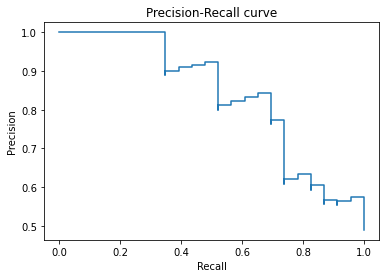

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

def read_annotated_pairs(file_path):
    scores = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(' :: ')
            if len(parts) == 2:
                sentence_pair, metadata = parts
                similarity, label = metadata.split(',')
                scores.append(float(similarity))
                labels.append(int(label))
    return scores, labels

def process_folder(folder_path):
    all_scores = []
    all_labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            scores, labels = read_annotated_pairs(file_path)
            all_scores.extend(scores)
            all_labels.extend(labels)
    return all_scores, all_labels

def plot_precision_recall_curve(scores, labels):
    precision, recall, _ = precision_recall_curve(labels, scores)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title('Precision-Recall curve')
    plt.show()

# Assuming the annotated files are located in 'annotated_files_folder'
annotated_files_folder = 'corpusdata/evalhi'
scores, labels = process_folder(annotated_files_folder)
plot_precision_recall_curve(scores, labels)


In [14]:
scores

[0.7589,
 0.7581,
 0.7436,
 0.6851,
 0.681,
 0.6634,
 0.6033,
 0.5092,
 0.7578,
 0.6796,
 0.674,
 0.7479,
 0.7392,
 0.7209,
 0.7167,
 0.704,
 0.6988,
 0.6908,
 0.6868,
 0.6842,
 0.6841,
 0.6795,
 0.6683,
 0.6445,
 0.6444,
 0.6342,
 0.825,
 0.8228,
 0.8033,
 0.7905,
 0.7812,
 0.7636,
 0.7561,
 0.7145,
 0.7097,
 0.7016,
 0.6569,
 0.6466,
 0.5655,
 0.9126,
 0.8567,
 0.8062,
 0.8011,
 0.7401,
 0.6342,
 0.6088,
 0.5772]

In [17]:
len(labels)

47

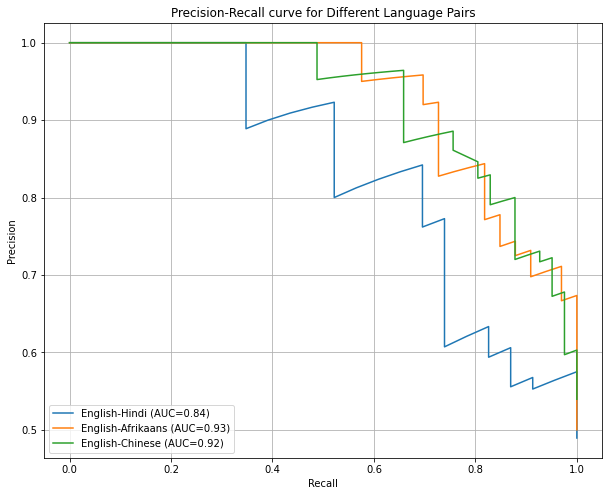

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def read_annotated_pairs(file_path):
    scores = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(' :: ')
            if len(parts) == 2:
                sentence_pair, metadata = parts
                similarity, label = metadata.split(',')
                scores.append(float(similarity))
                labels.append(int(label))
    return scores, labels

def process_folder(folder_path):
    all_scores = []
    all_labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            scores, labels = read_annotated_pairs(file_path)
            all_scores.extend(scores)
            all_labels.extend(labels)
    return all_scores, all_labels

def plot_precision_recall_curves(data_sets, labels):
    plt.figure(figsize=(10, 8))
    for data, label in zip(data_sets, labels):
        scores, labels = data
        precision, recall, _ = precision_recall_curve(labels, scores)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{label} (AUC={pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for Different Language Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Paths to the folders containing annotated files for different language pairs
folder_paths = [
    'corpusdata/evalhi',  # Path for Hindi-English evaluations
    'corpusdata/evalaf',  # Path for Afrikaans-English evaluations
    'corpusdata/evalzh'   # Path for Chinese-English evaluations
]
folder_labels = ['English-Hindi', 'English-Afrikaans', 'English-Chinese']

# Process each folder and store the results
data_sets = [process_folder(folder) for folder in folder_paths]

# Plotting the precision-recall curves
plot_precision_recall_curves(data_sets, folder_labels)


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_thresholds(data_sets, labels):
    plt.figure(figsize=(10, 8))

    for data, label in zip(data_sets, labels):
        scores, true_labels = data
        precision, recall, thresholds = precision_recall_curve(true_labels, scores)
        pr_auc = auc(recall, precision)

        # Find the threshold that gives the best F1 score
        f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
        best_f1_index = np.argmax(f1_scores)
        best_threshold = thresholds[best_f1_index]
        
        # Plot the precision-recall curve
        plt.plot(recall, precision, label=f'{label} (AUC={pr_auc:.2f})')
        
        # Annotate the best threshold (F1 score)
        plt.scatter(recall[best_f1_index], precision[best_f1_index], marker='o', label=f'Best for {label}: {best_threshold:.4f} (F1={f1_scores[best_f1_index]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for Different Language Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()


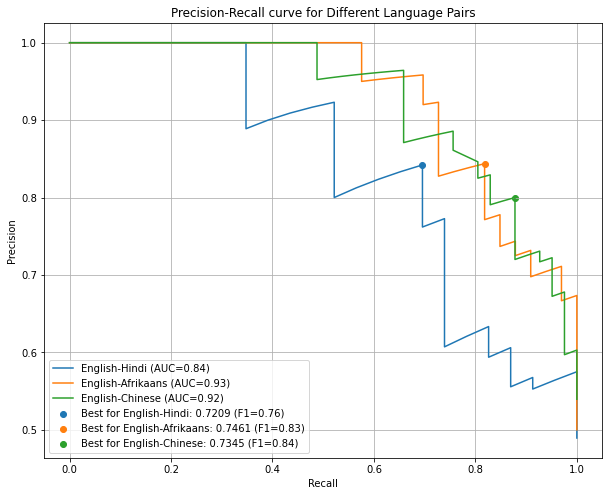

In [23]:
# Define the folder paths and corresponding labels
folder_paths = [
    'corpusdata/evalhi',
    'corpusdata/evalaf',
    'corpusdata/evalzh'
]
folder_labels = ['English-Hindi', 'English-Afrikaans', 'English-Chinese']

# Process the folders and collect the data
data_sets = [process_folder(folder) for folder in folder_paths]

# Call the plotting function
plot_precision_recall_thresholds(data_sets, folder_labels)


In [43]:
import os

def count_arrows_in_file(file_path):
    count = 0
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            count += line.count("--->")
    return count

def count_arrows_in_folder(folder_path):
    total_count = 0
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            file_count = count_arrows_in_file(file_path)
            total_count += file_count
            print(f"{file_name}: {file_count}")
    return total_count

In [46]:
# Folder path
folder_path = "corpusdata/evalzh"
# Count arrows in all files within the folder
total_arrows = count_arrows_in_folder(folder_path)
print(f"Total '--->' count in folder '{folder_path}': {total_arrows}")

Q22686_aligned.txt: 22
Q214426_aligned.txt: 2
Q15326_aligned.txt: 31
Q37643_aligned.txt: 9
Q223675_aligned.txt: 12
Total '--->' count in folder 'corpusdata/evalzh': 76


In [47]:
import os

def count_files_and_arrows(subfolder_path):
    txt_files_count = 0
    arrows_count = 0
    for file_name in os.listdir(subfolder_path):
        if file_name.endswith('.txt'):
            txt_files_count += 1
            file_path = os.path.join(subfolder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    arrows_count += line.count("--->")
    return txt_files_count, arrows_count

def count_in_all_subfolders(folder_path):
    subfolders_info = {}
    for subfolder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder_name)
        if os.path.isdir(subfolder_path):
            txt_files_count, arrows_count = count_files_and_arrows(subfolder_path)
            subfolders_info[subfolder_name] = {
                'txt_files_count': txt_files_count,
                'arrows_count': arrows_count
            }
    return subfolders_info


In [48]:
# Folder path
folder_path = "corpusdata/Aligned_Articles-LASER2-new"
# Count txt files and arrows in all subfolders
subfolders_info = count_in_all_subfolders(folder_path)

# Print the results
for subfolder_name, info in subfolders_info.items():
    print(f"Subfolder '{subfolder_name}':")
    print(f"  .txt files: {info['txt_files_count']}")
    print(f"  '--->' occurrences: {info['arrows_count']}")


Subfolder 'Aligned_Articles_Zh_Hi':
  .txt files: 360
  '--->' occurrences: 993
Subfolder 'Aligned_Articles_En_Af':
  .txt files: 450
  '--->' occurrences: 1704
Subfolder 'Aligned_Articles_En_Hi':
  .txt files: 449
  '--->' occurrences: 1855
Subfolder 'Aligned_Articles_En_Zh':
  .txt files: 433
  '--->' occurrences: 2328
Subfolder 'Aligned_Articles_Af_Zh':
  .txt files: 400
  '--->' occurrences: 1132
Subfolder 'Aligned_Articles_Af_Hi':
  .txt files: 295
  '--->' occurrences: 605
